In [1]:
import kagglehub

path = kagglehub.model_download("bibekbhusal0/digit-recognizer/pyTorch/1")
print("Path to model files:", path)


  0%|          | 0.00/28.7M [00:00<?, ?B/s]
  7%|▋         | 2.00M/28.7M [00:00<00:01, 17.7MB/s]
 17%|█▋        | 5.00M/28.7M [00:00<00:01, 21.3MB/s]
 31%|███▏      | 9.00M/28.7M [00:00<00:00, 20.9MB/s]
 45%|████▌     | 13.0M/28.7M [00:00<00:00, 26.5MB/s]
 59%|█████▉    | 17.0M/28.7M [00:00<00:00, 24.4MB/s]
 84%|████████▎ | 24.0M/28.7M [00:00<00:00, 35.7MB/s]
100%|██████████| 28.7M/28.7M [00:01<00:00, 28.7MB/s]

Path to model files: /root/.cache/kagglehub/models/bibekbhusal0/digit-recognizer/pyTorch/1/1


In [2]:
path = kagglehub.model_download("bibekbhusal0/generator/pyTorch/cganmnist")

print("Path to model files:", path)


  0%|          | 0.00/108M [00:00<?, ?B/s]
  2%|▏         | 2.00M/108M [00:00<00:05, 20.2MB/s]
  6%|▌         | 6.00M/108M [00:00<00:03, 28.1MB/s]
  8%|▊         | 9.00M/108M [00:00<00:04, 25.6MB/s]
 11%|█         | 12.0M/108M [00:00<00:03, 26.9MB/s]
 16%|█▌        | 17.0M/108M [00:00<00:02, 34.5MB/s]
 22%|██▏       | 24.0M/108M [00:00<00:02, 43.8MB/s]
 28%|██▊       | 30.0M/108M [00:00<00:01, 47.8MB/s]
 32%|███▏      | 35.0M/108M [00:00<00:01, 48.0MB/s]
 39%|███▉      | 42.0M/108M [00:01<00:01, 54.2MB/s]
 44%|████▍     | 48.0M/108M [00:01<00:01, 52.3MB/s]
 55%|█████▍    | 59.0M/108M [00:01<00:00, 69.4MB/s]
 61%|██████    | 66.0M/108M [00:01<00:00, 68.7MB/s]
 67%|██████▋   | 73.0M/108M [00:01<00:00, 67.5MB/s]
 76%|███████▌  | 82.0M/108M [00:01<00:00, 74.7MB/s]
100%|██████████| 108M/108M [00:01<00:00, 62.2MB/s] 

Path to model files: /root/.cache/kagglehub/models/bibekbhusal0/generator/pyTorch/cganmnist/1


In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
import cv2
from PIL import Image

import torch
from torch import nn
from torchvision.utils import make_grid, save_image

In [4]:
def normale_dondurme(x):
  out = (x + 1) / 2
  out = out.clamp(0, 1)
  out = out.reshape(out.size(0), 1, 28, 28)
  return out

def gorsellestirme(x, nrows = 8):
  plt.imshow(make_grid(normale_dondurme(x), nrow = nrows).cpu().permute(1, 2, 0))
  plt.axis('off')
  plt.tight_layout()
  plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.latent_dim = 1024
    self.embedding_dim = 128

    def traverseConv(in_chanels, out_chanels, kernel_size = 4, stride = 2, padding = 1, relu = True):
      layers = [
          nn.ConvTranspose2d(in_chanels, out_chanels, kernel_size, stride, padding, bias = False),
          nn.BatchNorm2d(out_chanels)
      ]
      if relu:
        layers.append(nn.LeakyReLU(0.2))
      return layers

    self.main = nn.Sequential(
        *traverseConv(256 * 2 + 1, 256 ),
        *traverseConv(128 * 2, 128 ),
        nn.Conv2d(128 , 1, 3, 1, 1, bias = False),
        nn.Tanh()
    )

    self.latent = nn.Sequential(
        nn.Linear(self.latent_dim, 7 * 7 * 512 ),
        nn.LeakyReLU(0.2)
    )
    self.embedding = nn.Sequential(
        nn.Embedding(10, self.embedding_dim),
        nn.Linear(self.embedding_dim, 7 * 7 )
    )
    self.to(device)

  def noise(self, samples = 1):
    return torch.randn(samples, self.latent_dim ).to(device)

  def combine(self, noise, label):
    noise = self.latent(noise)
    label = self.embedding(label.to(device))
    label = label.view(-1, 1, 7, 7)
    noise = noise.view(-1, 512, 7, 7)
    x = torch.cat((noise, label), 1)

    return x

  def noise_with_label(self, labels):
    return self.combine(self.noise(labels.shape[0]), labels)

  def random_labels(self, samples = 1):
    return torch.randint(0, 10, (samples, )).to(device)

  def generate_random(self, samples):
    return self.generate(self.random_labels(samples))

  def generate_10(self, samples):
    labels = torch.arange(10 * samples, device = device)
    labels = labels % 10
    return self.generate(labels)

  def generate(self, labels):
    return (self(self.noise_with_label(labels)))

  def forward(self, x):
    return self.main(x.to(device))

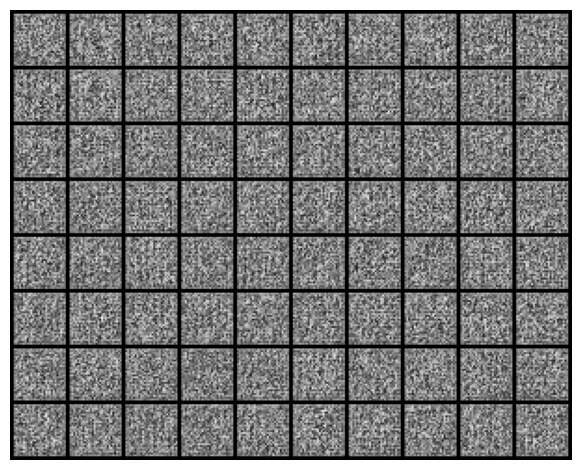

In [7]:
generator = Generator()
gorsellestirme(generator.generate_10(8), 10)

In [9]:
model_path = '/content/generator.pth'
pretrained_model = torch.load(model_path, map_location = device)

generator.load_state_dict(pretrained_model)
generator.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(513, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): Tanh()
  )
  (latent): Sequential(
    (0): Linear(in_features=1024, out_features=25088, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (embedding): Sequential(
    (0): Embedding(10, 128)
    (1): Linear(in_features=128, out_features=49, bias=True)
  )
)

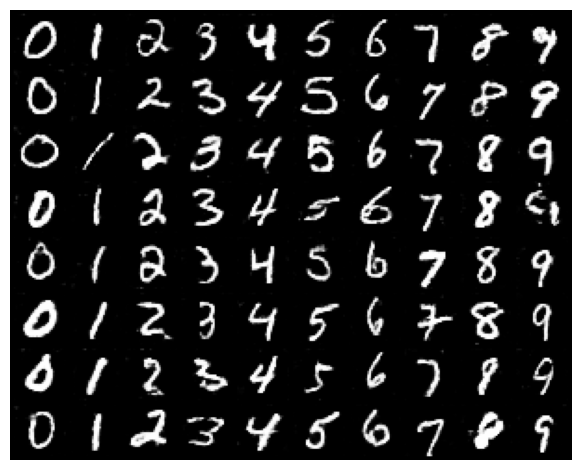

In [10]:
gorsellestirme(generator.generate_10(8), 10)

In [11]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.main =  nn.Sequential(
            nn.Conv2d(1, 32, kernel_size  = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size  = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size  = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128 * 3),
            nn.ReLU(),
            nn.Linear(128 * 3 , 10),
            nn.Softmax()
        )
        self.to(device)

    def forward(self, x):
        return self.main(x.to(device))

    def recognize(self, x):
        prediction = self(x + 0.5)
        return prediction.cpu().detach().numpy()

In [12]:
recognizer = DigitRecognizer()

In [13]:
digit_r_path = '/content/digitRecognizer.pth'
pretrained_digit_recognizer = torch.load(digit_r_path, map_location = device)
recognizer.load_state_dict(pretrained_digit_recognizer['model'])
recognizer.eval()

DigitRecognizer(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=384, bias=True)
    (9): ReLU()
    (10): Linear(in_features=384, out_features=10, bias=True)
    (11): Softmax(dim=None)
  )
)

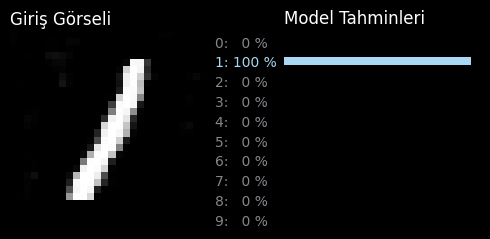

In [14]:
def image_and_pred(noise, show=True, save=False, path=None):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(5, 2.5))
    fig.patch.set_facecolor('black')
    img = generator(noise)
    pred = recognizer.recognize(img)
    img = img.detach().cpu()
    img = img.reshape(28, 28)
    ax1.imshow(img, cmap='gray')
    y = np.arange(10)
    ticks = []

    for i in y:
        ticks.append(f'{i}: {str(round(pred[0][i] * 100)).rjust(3)} %')

    cmap_colors = ['#83868F', '#9EDAFF']
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

    colors = custom_cmap(pred[0])
    barplot = sns.barplot(y=y, x=pred[0], orient='h', ax=ax2, palette=colors)

    ax1.axis('off')
    ax2.set_facecolor('black')
    ax2.tick_params(axis='y', colors='white', which='both', left=False, right=False, bottom=False, top=False)
    ax2.set_xticks([])
    ax2.set_yticklabels(ticks, ha='left')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.set_title('Giriş Görseli', color='white', loc='left')
    ax2.set_title('Model Tahminleri', color='white', loc='left')

    for bar, tick in zip(barplot.patches, ax2.yaxis.get_majorticklabels()):
        tick.set_x(bar.get_x() - 0.3)
        tick.set_color(bar.get_facecolor())
        bar.set_height(0.4)
        bar.set_y(tick.get_position()[1] - 0.2)

    plt.tight_layout()
    if save:
        fig.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

image_and_pred(generator.noise_with_label(torch.randint(0, 10, (1,))), show=True)

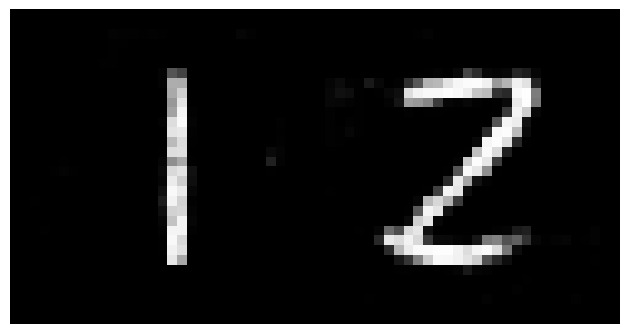

In [15]:
one_noise = generator.noise_with_label(torch.tensor([1]))
two_noise = generator.noise_with_label(torch.tensor([2]))

gorsellestirme(generator(torch.cat((one_noise, two_noise))), 2)

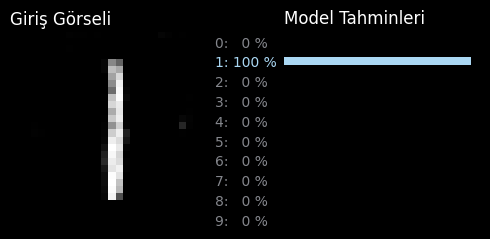

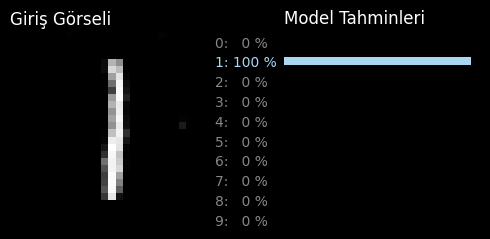

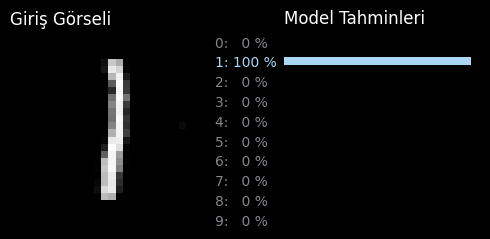

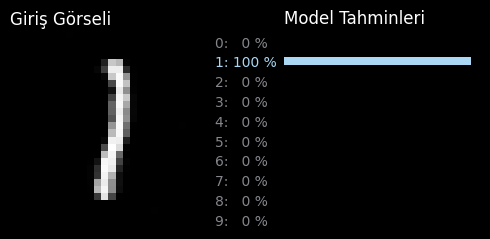

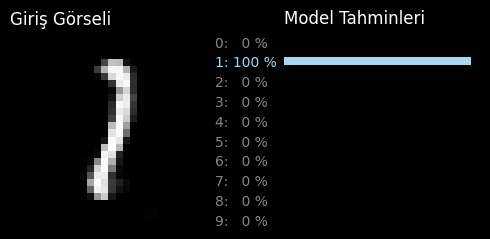

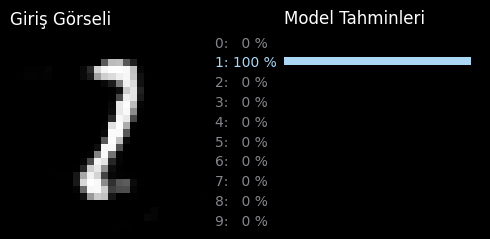

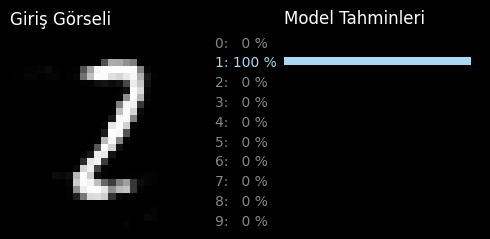

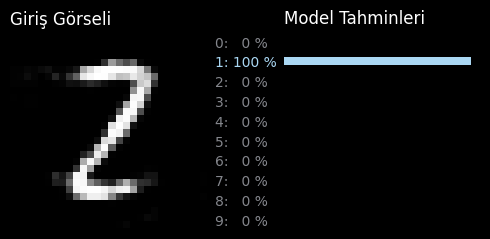

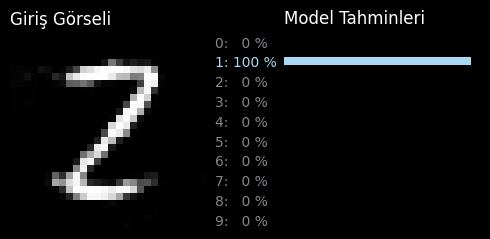

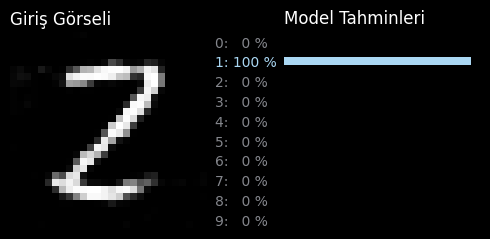

In [16]:
diff = one_noise - two_noise
frac = diff / 10

for i in range(10):
  noise = one_noise - frac * (i + 1)
  image_and_pred(noise, show = True)

In [17]:
folder = 'zero_to_nine'
os.makedirs(folder, exist_ok = True)

for i in range(200):
    num = i % 10
    crr = generator.noise_with_label(torch.tensor([num]))
    if i == 0:
        prev = crr
        continue

    diff = prev - crr
    frac = diff / 10

    for j in range (10):
        file_name = f'{str(i).zfill(4)}_{str(j).zfill(2)}.png'
        path = os.path.join(folder, file_name)
        noise = prev - frac * (j + 1)
        image_and_pred(noise, show = False, save = True, path = path)
    prev = crr


In [18]:
image_names = os.listdir(folder)
images = [Image.open(os.path.join(folder, name) ) for name in sorted(image_names)]

In [19]:
frame_rate = 10
duration = 1000 // frame_rate
images[0].save(
    'zero_to_nine.gif',
    save_all = True,
    append_images = images[1:],
    duration = duration,
    loop = 0
)

In [21]:
size = images[0].size
vid_writer = cv2.VideoWriter(
    'zero_to_nine.mp4',
    cv2.VideoWriter_fourcc(*'mp4v'),
    frame_rate,
    size
)

for img in images:
  vid_writer.write(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

vid_writer.release()

In [22]:
folder = 'rand'
os.makedirs(folder, exist_ok = True)

for i in range(200):
    crr = generator.noise_with_label(generator.random_labels(1))
    if i == 0:
        prev = crr
        continue

    diff = prev - crr
    frac = diff / 10

    for j in range (10):
        file_name = f'{str(i).zfill(4)}_{str(j).zfill(2)}.png'
        path = os.path.join(folder, file_name)
        noise = prev - frac * (j + 1)
        image_and_pred(noise, show = False, save = True, path = path)
    prev = crr

In [23]:
image_names = os.listdir(folder)
images = [Image.open(os.path.join(folder, name) ) for name in sorted(image_names)]

In [24]:
frame_rate = 10
duration = 1000 // frame_rate
images[0].save(
    'rand.gif',
    save_all = True ,
    append_images = images[1:],
    duration = duration,
    loop = 0
)

In [25]:
size = images[0].size
vid_writer = cv2.VideoWriter(
    'rand.mp4',
    cv2.VideoWriter_fourcc(*'mp4v'),
    frame_rate,
    size,
)

for img in images:
    vid_writer.write(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

vid_writer.release()